In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key is None:
    print('API key found')
else:
    print('API key not found')

API key not found


In [3]:
# from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from langchain_openai import OpenAIEmbeddings
from chromadb import PersistentClient, EmbeddingFunction, Embeddings
from typing import List
import json

In [5]:
MODEL_NAME = 'text-embedding-3-large'
DB_PATH = './.chroma_db'
FAQ_FILE_PATH = './FAQ.json'
INVENTORY_FILE_PATH = './inventory.json'

# step1: load document

In [14]:
with open('FAQ.json', 'r') as f:
    faqs = json.load(f)

faqs

[{'question': 'What types of flowers do you offer?',
  'answer': 'We offer a wide variety of flowers including roses, lilies, tulips, sunflowers, orchids, and seasonal bouquets. Our selection changes regularly to ensure freshness and variety.'},
 {'question': 'How do I place an order?',
  'answer': "You can place an order easily through our website. Simply browse our selection, choose your desired flowers, add them to your cart, and proceed to checkout. You'll need to provide delivery details and payment information to complete your order."},
 {'question': 'What are your delivery options?',
  'answer': "We offer same-day delivery for orders placed before noon, next-day delivery, and scheduled delivery for future dates. Delivery options may vary based on your location and the availability of the flowers you've selected."},
 {'question': 'Do you offer international shipping?',
  'answer': "Currently, we only offer delivery within the country. We're working on expanding our services inter

In [28]:
len([faq['question'] for faq in faqs] + [faq['answer'] for faq in faqs])

40

## step 2: load the document into collection

In [7]:
db = PersistentClient(path = DB_PATH)

In [21]:
# create collection
from typing import List
from chromadb import Documents, EmbeddingFunction, Embeddings

class MyEmbeddingClass(EmbeddingFunction):
    def __init__(self, model_name):
        self.embedding_model = OpenAIEmbeddings(model = model_name)
    
    def __call__(self, input_texts:List[str])->Embeddings:
        text_embeddings = []
        for text in input_texts:
            text_embed = self.embedding_model.embed_query(text)
            text_embeddings.append(text_embed)
        return text_embeddings 

my_embedding_function = MyEmbeddingClass(MODEL_NAME)
faq_collection = db.get_or_create_collection(name='FAQ',
                                             embedding_function = my_embedding_function
                                             )

In [22]:
# loading the document in 
if faq_collection.count()==0:
    faq_collection.add(documents = [faq['question'] for faq in faqs] + [faq['answer'] for faq in faqs],
                       ids = [str(i) for i in range(0, (2*len(faqs)))],
                       metadatas = faqs+faqs
                       )

In [26]:
faq_collection.query(query_texts=['what are the different types of flowers i can have?'], n_results=5)

{'ids': [['0', '18', '20', '15', '4']],
 'embeddings': None,
 'documents': [['What types of flowers do you offer?',
   'How do I know which flowers are appropriate for different occasions?',
   'We offer a wide variety of flowers including roses, lilies, tulips, sunflowers, orchids, and seasonal bouquets. Our selection changes regularly to ensure freshness and variety.',
   'Do you offer flower care tips?',
   'How do I ensure my flowers stay fresh?']],
 'uris': None,
 'data': None,
 'metadatas': [[{'answer': 'We offer a wide variety of flowers including roses, lilies, tulips, sunflowers, orchids, and seasonal bouquets. Our selection changes regularly to ensure freshness and variety.',
    'question': 'What types of flowers do you offer?'},
   {'answer': 'Our website provides guidance on flower meanings and appropriate choices for various occasions. You can also chat with our customer service team for personalized recommendations.',
    'question': 'How do I know which flowers are appr

In [31]:
from chromadb import PersistentClient, EmbeddingFunction, Embeddings
from langchain_openai import OpenAIEmbeddings
from typing import List
import json
import os
from dotenv import load_dotenv

#loading openai api_key
load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')

# constants
MODEL_NAME = 'text-embedding-3-large'
DB_PATH = './.chroma_db'
FAQ_FILE_PATH = './data/FAQ.json'
INVENTORY_FILE_PATH = './data/inventory.json'

## Load data 
class LoadData:
    def __init__(self):
        pass

    def load_faq_data(self, faq_path):
        with open(faq_path, 'r') as f:
            faqs_json = json.load(f)
        faq_docs = [faq['question'] for faq in faqs_json] + [faq['answer'] for faq in faqs_json]
        return faqs_json, faq_docs
    
    def load_inventory(self, inventory_path):
        with open(inventory_path, 'r') as f:
            inventory_json = json.load(f)
        inventory_docs = [data['description'] for data in inventory_json]
        return inventory_json, inventory_docs



## Embedding Class to embedding the text
class MyEmbeddingClass(EmbeddingFunction):
    def __init__(self, model_name):
        self.embedding_model = OpenAIEmbeddings(model=model_name)
    
    def __call__(self, input_texts:List[str])->Embeddings:
        embedding_list = []
        for text in input_texts:
            text_embed = self.embedding_model.embed_query(text)
            embedding_list.append(text_embed)
        return embedding_list


        
## FlowerShop Vector Store
class FlowerShopVectorStore:
    def __init__(self):
        db = PersistentClient(path=DB_PATH)
        custom_embedding_function = MyEmbeddingClass(MODEL_NAME)

        # create collection 
        self.faq_collection = db.get_or_create_collection(name='FAQ', embedding_function = custom_embedding_function)
        self.inventory_collection = db.get_or_create_collection(name='inventory', embedding_function = custom_embedding_function)


    # load data in collection
    def load_data_in_collection(self, faq_path, inventory_path):
        load_data = LoadData()

        if self.faq_collection.count()==0:
            faq_json, faq_docs = load_data.load_faq_data(faq_path)
            self.faq_collection.add(documents = faq_docs,
                                    ids = [str(i) for i in range(0, len(faq_docs))],
                                    metadatas = faq_json + faq_json
                                    )
            
            print('Done indexing the FAQ data...')
        
        if self.inventory_collection.count()==0:
            inventory_json, inventory_docs = load_data.load_inventory(inventory_path)
            self.inventory_collection.add(documents = inventory_docs,
                                        ids = [str(i) for i in range(len(inventory_docs))],
                                        metadatas = inventory_json
                                        )
            print('Done indexing the inventory data...')
            
    def query_faqs(self, query:str):
        return self.faq_collection.query(query_texts=[query], n_results=5)
    
    def query_inventories(self, query:str):
        return self.inventory_collection.query(query_texts=[query], n_results=5)
    

if __name__ == '__main__':
    vs = FlowerShopVectorStore()
    # vs.load_data_in_collection(FAQ_FILE_PATH, INVENTORY_FILE_PATH)
    answer = vs.query_faqs('what are the different types of flowers do you have?')

In [32]:
answer

{'ids': [['0', '20', '18', '15', '17']],
 'embeddings': None,
 'documents': [['What types of flowers do you offer?',
   'We offer a wide variety of flowers including roses, lilies, tulips, sunflowers, orchids, and seasonal bouquets. Our selection changes regularly to ensure freshness and variety.',
   'How do I know which flowers are appropriate for different occasions?',
   'Do you offer flower care tips?',
   'Do you offer gift options besides flowers?']],
 'uris': None,
 'data': None,
 'metadatas': [[{'answer': 'We offer a wide variety of flowers including roses, lilies, tulips, sunflowers, orchids, and seasonal bouquets. Our selection changes regularly to ensure freshness and variety.',
    'question': 'What types of flowers do you offer?'},
   {'answer': 'We offer a wide variety of flowers including roses, lilies, tulips, sunflowers, orchids, and seasonal bouquets. Our selection changes regularly to ensure freshness and variety.',
    'question': 'What types of flowers do you offe

In [33]:
type(answer)

dict

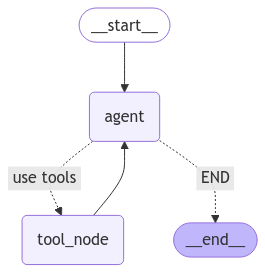

In [46]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode
# from tools import query_knowledge_base_tool, search_for_product_recommendation_tool
from dotenv import load_dotenv
import os

from langchain_core.tools import tool
from typing import List, Dict
from vector_store import FlowerShopVectorStore

vector_store = FlowerShopVectorStore()

@tool
def query_knowledge_base_tool(query:str):
    """
    Looks up the information in knowledge base to help with answering customer questions and getting information on business processes.
    
    Args:
        query(str) : Question to ask the knowledge base
    
    Return:
        Dict[str, str] : Potentially relevant question and answering pairs for the knowledge base
    """
    return vector_store.query_faqs(query=query)


@tool
def search_for_product_recommendations_tool(description:str):
    """
    Looks up information in a knowledge base to help with product recommendation for customers. For example:
    <example>
        1. Boquets are suitable for birthdays, maybe with red flowers
        2. A large boquet for a wedding
        3. A cheap boquet with wildflowers
    </example>

    Args:
        description (str) : Description of product features

    Return:
        Dict[str, str] : Potentially relevant features
    """
    return vector_store.query_inventories(query=description)


# loading api_key
load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')

# creating prompt template
prompt = """
        You are a customer service chatbot for a flower shop company. You can help the customer achieve the goals listed below.
        <Goals>
            1. Answer the questions the user might have relating to services offered
            2. Recommend products to the user based on their preferences.
        </Goals>

        <Tone>
            Helpful and frienly. Use some gen-z emojis to keep things fun and lighthearted. You MUST always include a funny related pun in every response.
        </Tone>
    """

prompt_template = ChatPromptTemplate.from_messages(
    [
        ('system', prompt),
        ('placeholder', "{messages}")
    ]
)

# creating LLM and binding tools
llm = ChatOpenAI(model = "gpt-40-mini", openai_api_key = api_key)
tools = [query_knowledge_base_tool, search_for_product_recommendations_tool]
llm_with_prompt = ChatPromptTemplate | llm.bind_tools(tools=tools)

# creating state graph
def call_agent(message_state: MessagesState):
    response = llm_with_prompt.invoke(message_state)
    return {'messages': response}


def is_there_tool_calls(message_state:MessagesState):
    last_message = message_state['messages'][-1]
    if last_message.tool_calls:
        return 'use tools'
    else:
        return 'END'

### Note : 2 nodes (agent, tool_node) , 1 conditional edge between agent and tool
graph_builder = StateGraph(MessagesState)

graph_builder.add_node('agent', call_agent)
graph_builder.add_node('tool_node', ToolNode(tools))

graph_builder.add_conditional_edges('agent', 
                                    is_there_tool_calls, 
                                    {'use tools':'tool_node', 'END':END}
                                    )
graph_builder.add_edge('tool_node', 'agent')
graph_builder.add_edge(START, 'agent')

# creating app
app = graph_builder.compile()




from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

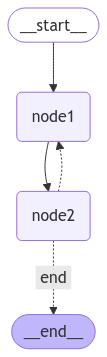

In [2]:
from typing import Literal, TypedDict
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, field_validator, ValidationError
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

class State(TypedDict):
    input : int 

def node1(state:State):
    print('node1')
    return state


def node2(state:State):
    print('node2')
    state['input'] = state['input']*7
    return state

def should_continue(state:State):
    if state['input']<1000:
        return 'node1'
    else:
        return 'end'
    

builder = StateGraph(State)
builder.add_node('node1', node1)
builder.add_node('node2', node2)

#adding edges
builder.add_edge(START, 'node1')
builder.add_edge('node1', 'node2')
builder.add_conditional_edges('node2',should_continue, {'node1':'node1', 'end':END})
graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({'input':2})

node1
node2
node1
node2
node1
node2
node1
node2


{'input': 4802}

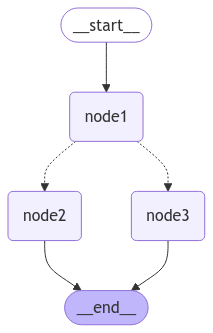

In [51]:
from typing import Literal, TypedDict
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name : str
    mood : str 

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        if value not in ['happy', 'sad']:
            raise ValueError('Mood must be either sad or happy.')
        return value



def node1(state):
    print('--NODE1--')
    return {'name':state.name+' is ... '}

def node2(state):
    print('--NODE2--')
    return {'mood':state.mood}

def node3(state):
    print('--NODE3--')
    return {'mood':state.mood}


def decide_mood(state)->Literal['node2', 'node3']:
    if random.random()<0.5:
        return 'node2'
    else:
        return 'node3'

builder = StateGraph(PydanticState)
builder.add_node('node1', node1)
builder.add_node('node2', node2)
builder.add_node('node3', node3)

builder.add_edge(START, 'node1')
builder.add_conditional_edges('node1', decide_mood)
builder.add_edge('node2', END)
builder.add_edge('node3', END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
graph.invoke(PydanticState(name='Prem', mood='happy'))

--NODE1--
--NODE3--


{'name': 'Prem is ... ', 'mood': 'sad'}

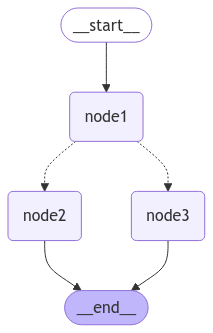

NODE1
NODE3


{'name': 'Prem is ... ', 'mood': 'sad'}

In [54]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name : str
    mood : str

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        if value not in ['happy', 'sad']:
            raise ValueError('Mood must be either between happy or sad')
        return value 
    
try:
    PydanticState(name='Prem', mood='sad')
except ValidationError as ex:
    print(ex)


##################################################    
def node1(state):
    print('NODE1')
    return {'name':state.name+' is ... '}

def node2(state):
    print('NODE2')
    return {'mood':state.mood}

def node3(state):
    print('NODE3')
    return {'mood':state.mood}

def decide_mood(state):
    if random.random()<0.5:
        return 'node2'
    return 'node3'

builder = StateGraph(PydanticState)
builder.add_node('node1', node1)
builder.add_node('node2', node2)
builder.add_node('node3', node3)

builder.add_edge(START, 'node1')
builder.add_conditional_edges('node1', decide_mood, {'node2':'node2', 'node3':'node3'})
builder.add_edge('node2', END)
builder.add_edge('node3', END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke(PydanticState(name='Prem', mood='sad'))

In [90]:
def reduce_list(left:Optional[List[Union[int,None]]], right:Optional[List[Union[int, None]]])->List[Optional[int]]:
    if left is None:
        left = []
    if right is None:
        right = []
    return left + right

reduce_list([5, None], )

TypeError: reduce_list() missing 1 required positional argument: 'right'

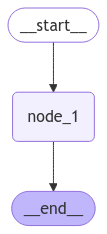

In [92]:
from pydantic import BaseModel
from langgraph.graph.state import StateGraph, START, END
from operator import add
from typing import Annotated, List, Union, Optional

def reduce_list(left:Optional[List[Union[int,None]]], right:Optional[List[Union[int, None]]])->List[Optional[int]]:
    if left is None:
        left = []
    if right is None:
        right = []
    return left + right

class State(BaseModel):
    foo : Annotated[List[Union[int, None]], reduce_list]

def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [93]:
from langgraph.errors import InvalidUpdateError
try:
    print(graph.invoke({'foo':[None]}))
except InvalidUpdateError as e:
    print('InvalidUpdateError occured:', e)

---Node 1---
{'foo': [None, 2]}


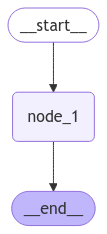

---Node 1---
{'foo': [4, 2]}


In [95]:
def reduce_list(left: list | None, right: list | None) -> list:
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : [4]}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

In [106]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage
import pprint

inital_messages = [
    HumanMessage(content='Hi, this is KP', name='KP', id='1'),
    AIMessage(content='Hi KP, how are you?', name='Model', id='2')
]

final_message = add_messages(inital_messages, HumanMessage(content='I need info on MSD', id='1'))
pprint.pprint(final_message)

[HumanMessage(content='I need info on MSD', additional_kwargs={}, response_metadata={}, id='1'),
 AIMessage(content='Hi KP, how are you?', additional_kwargs={}, response_metadata={}, name='Model', id='2')]


In [107]:
from langchain_core.messages import RemoveMessage

messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

delete_message = [RemoveMessage(id='3')]
add_messages(messages, delete_message)

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

In [108]:
delete_message

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='3')]

## Trim Messages

In [110]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Bot"),
            HumanMessage(content=f"Yes, I know about whales. But what others should I learn about?", name="Lance")
            ]

for msg in messages:
    msg.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [112]:
from langchain_openai import ChatOpenAI
import pprint

llm = ChatOpenAI(model='gpt-4o-mini')
pprint.pprint(llm.invoke(messages))

AIMessage(content='In addition to whales, there are several fascinating ocean mammals you might want to learn about:\n\n1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and complex communication.\n\n2. **Porpoises**: Similar to dolphins but generally smaller and with a more rounded snout, porpoises are also social animals but tend to be less acrobatic.\n\n3. **Seals**: These pinnipeds include species like harbor seals and elephant seals. They are known for their ability to navigate both land and water.\n\n4. **Sea Lions**: Similar to seals but with external ear flaps and a more social nature, sea lions are often seen in large groups.\n\n5. **Manatees**: Also known as sea cows, these gentle herbivores inhabit warm coastal waters and are known for their slow-moving, peaceful nature.\n\n6. **Dugongs**: Similar to manatees, dugongs are marine herbivores found in warm coastal waters, primarily in the Indian and western Pacific Oceans.\n

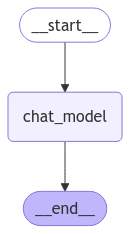

In [113]:
from langgraph.graph.message import add_messages
from langgraph.graph.state import StateGraph, START, END
from typing import Annotated, List
from typing_extensions import TypedDict

class State(TypedDict):
    messages : Annotated[List, add_messages]


def chat_model_node(state):
    return {'messages':llm.invoke(state['messages'])}

builder = StateGraph(State)
builder.add_node('chat_model', chat_model_node)
builder.add_edge(START, 'chat_model')
builder.add_edge('chat_model', END)

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [114]:
output = graph.invoke({'messages':messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you might want to learn about:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are social animals that often live in pods.

2. **Porpoises**: Similar to dolphins but generally smaller and with a different snout shape, porpoises are also social creatures.

3. **Seals**: These marine mammals are commonly found on coasts and are known for their playful nature. They can be divided into true seals (phocids) and eared seals (otariids).

4. **Sea Lions**: A type of eared seal, sea lions are known for their external ear

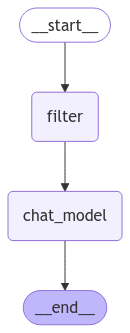

In [118]:
from langchain_core.messages import RemoveMessage

class State(TypedDict):
    messages : Annotated[List, add_messages]

def filter_message(state:State):
    delete_message = [RemoveMessage(id=msg.id) for msg in state['messages'][:-2]]
    return {'messages':delete_message}

def chat_model_node(state:State):
    return {'messages':llm.invoke(state['messages'])}

builder = StateGraph(State)
builder.add_node('filter', filter_message)
builder.add_node('chat_model', chat_model_node)
builder.add_edge(START, 'filter')
builder.add_edge('filter', 'chat_model')
builder.add_edge('chat_model', END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [119]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

output = graph.invoke({'messages':messages})
for msg in output['messages']:
    msg.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you might want to learn about:

1. **Dolphins**: Known for their intelligence and social behavior, dolphins are highly communicative and often found in pods. The bottlenose dolphin is one of the most well-known species.

2. **Porpoises**: Similar to dolphins but generally smaller and with a more rounded snout, porpoises are also social animals and can be found in coastal waters.

3. **Seals**: There are various species of seals, including harbor seals and elephant seals. They are known for their playful behavior and can often be seen resting

In [120]:
messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

In [121]:
output

{'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
  AIMessage(content='In addition to whales, there are several other fascinating ocean mammals you might want to learn about:\n\n1. **Dolphins**: Known for their intelligence and social behavior, dolphins are highly communicative and often found in pods. The bottlenose dolphin is one of the most well-known species.\n\n2. **Porpoises**: Similar to dolphins but generally smaller and with a more rounded snout, porpoises are also social animals and can be found in coastal waters.\n\n3. **Seals**: There are various species of seals, including harbor seals and elephant seals. They are known for their playful behavior and can often be seen resting on beaches.\n\n4. **Sea Lions**: These are ofte

In [122]:
messages.append(output['messages'][-1])
messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
 AIMessage(content='In addition to whales, there are several other fascinating ocean mammals you might want to learn about:\n\n1. **Dolphins**: Known for their intelligence and social behavior, dolphins are highly communicative and often found in pods. The bottlenose dolphin is one of the most well-known species.\n\n2. **Porpoises**: Similar to dolphins but generally smaller and with a more rounded snout, porpoises are also social animals and can be found in coastal waters.\n\n3. **Seals**: There are various species 

In [123]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you might want to learn about:

1. **Dolphins**: Known for their intelligence and social behavior, dolphins are highly communicative and often found in pods. The bottlenose dolphin is one of the most well-known species.

2. **Porpoises**: Similar to dolphins but generally smaller and with a more rounded snout, porpoises are also social animals and can

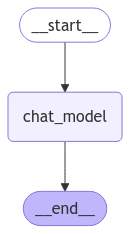

In [124]:
from langchain_core.messages import AIMessage, HumanMessage, trim_messages


class State(TypedDict):
    messages : Annotated[List, add_messages]

def chat_model_node(state:State):
    messages = trim_messages(state['messages'], max_tokens=100,
                             strategy='last', token_counter=ChatOpenAI(model='gpt-4o-mini'),
                             allow_partial=True)
    
    return {'messages':llm.invoke(messages)}

builder = StateGraph(State)
builder.add_node('chat_model', chat_model_node)
builder.add_edge(START, 'chat_model')
builder.add_edge('chat_model', END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [125]:
messages.append(HumanMessage(content='Tell me where Orcas Live!', name = 'Lance'))
messages_out_trim = graph.invoke({'messages':messages})
print(messages_out_trim)

{'messages': [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'), HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'), AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'), AIMessage(content='In addition to whales, there are several other fascinating ocean mammals you might want to learn about:\n\n1. **Dolphins**: Known for their intelligence and social behavior, dolphins are highly communicative and often found in pods. The bottlenose dolphin is one of the most well-known species.\n\n2. **Porpoises**: Similar to dolphins but generally smaller and with a more rounded snout, porpoises are also social animals and can be found in coastal waters.\n\n3. **Seals**: There are various

### Build with summary

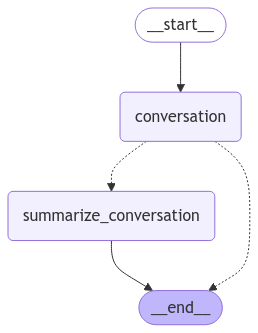

In [3]:
from langgraph.graph.state import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, List
from typing_extensions import TypedDict
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage


class State(TypedDict):
    messages : Annotated[List,add_messages]
    summary : str

def call_model(state:State):
    summary = state.get('summary', '')
    if summary:
        sys_msg = f"Summary of the conversation earlier: {summary}"
        messages = [SystemMessage(content=sys_msg)] + state['messages']
    else:
        messages = state['messages']

    response = llm.invoke(messages)
    return {'messages':response}


def summarize_conversation(state:State):
    summary = state.get('summary', '')
    if summary:
        summary_msg = (
            f"""
            This is summary of conversation to date: {summary} \n\n.
            Extend the summary by taking into account the new messages above:
            """
        )
    else:
        summary_message = "create a summary of the conversation of the above"
    
    messages = state['messages'] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)

    delete_message = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
    return {'summary':response.content, 'messages':delete_message}

def should_continue(state:State):
    messages = state['messages']
    if len(messages)>6:
        return 'summarize_conversation'
    return END 

from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
!pip install langgraph-checkpoint-sqlite

## Streaming

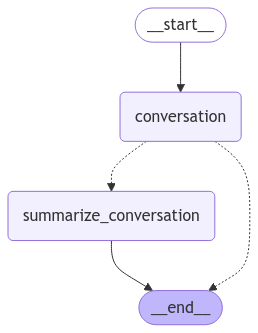

In [5]:
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.state import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, List
from typing_extensions import TypedDict

class State(TypedDict):
    messages : Annotated[List, add_messages]
    summary : str


def call_model(state:State, config:RunnableConfig):
    summary = state.get('summary', '')
    if summary:
        system_message = f"Summary of the conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state['messages']
    else:
        messages = state['messages']

    response = llm.invoke(messages, config)
    return {'messages': response}


def summarize_conversation(state:State):
    summary = state.get('summary', '')
    if summary:
        summary_msg = f"""
                            This is summary of the conversation to date : {summary}.\n
                            Extend this summary using the new conversation given above.
                            """
        
    else:
        summary_msg = "Create the summary of the conversation given above:"
    
    messages = state['messages'] + [HumanMessage(content=summary_msg)]
    response = llm.invoke(messages)
    delete_msg = [RemoveMessage(id = m.id) for m in state['messages'][:-2]]
    return {'summary':response.content, 'messages':delete_message}

def should_continue(state:State):
    messages = state['messages']
    if len(messages)>6:
        return 'summarize_conversation'
    else:
        return END

builder = StateGraph(State)
builder.add_node('conversation', call_model)
builder.add_node('summarize_conversation', summarize_conversation)
builder.add_edge(START, 'conversation')
builder.add_conditional_edges('conversation', should_continue)
builder.add_edge('summarize_conversation', END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
llm = ChatOpenAI(model='gpt-4o-mini')
config = {'configurable':{'thread_id':1}}
for chunk in graph.stream({'messages':HumanMessage(content='Hi, i am Prem')}, config=config, stream_mode='updates'):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hi Prem! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 21, 'total_tokens': 31, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'stop', 'logprobs': None}, id='run-ad6f234c-3bdb-402d-934f-7da0e12c4a15-0', usage_metadata={'input_tokens': 21, 'output_tokens': 10, 'total_tokens': 31, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [9]:
config ={'configurable':{'thread_id':1}}
input_message = HumanMessage(content='Hi this is KP')
for event in graph.stream({'messages':input_message}, config=config, stream_mode='values'):
    for m in event['messages']:
        m.pretty_print()
    print('--'*25)

================================ Human Message =================================

Hi, i am Prem
================================ Human Message =================================

Hi, i am Prem
================================== Ai Message ==================================

Hi Prem! How can I assist you today?
================================ Human Message =================================

Hi this is KP
================================ Human Message =================================

Hi this is KP
--------------------------------------------------
================================ Human Message =================================

Hi, i am Prem
================================ Human Message =================================

Hi, i am Prem
================================== Ai Message ==================================

Hi Prem! How can I assist you today?
================================ Human Message =================================

Hi this is KP
================================ Human 

In [10]:
config = {'configurable':{'thread_id':3}}
input_message = HumanMessage(content='Tell me about csk')
async for event in graph.astream_events({'messages':input_message}, config=config, version='v2'):
    print(f"Node:{event['metadata'].get('langgraph_node', '')}. Type:{event['event']}. Name:{event['name']}")

Node:. Type:on_chain_start. Name:LangGraph
Node:__start__. Type:on_chain_start. Name:__start__
Node:__start__. Type:on_chain_end. Name:__start__
Node:conversation. Type:on_chain_start. Name:conversation
Node:conversation. Type:on_chat_model_start. Name:ChatOpenAI
Node:conversation. Type:on_chat_model_stream. Name:ChatOpenAI
Node:conversation. Type:on_chat_model_stream. Name:ChatOpenAI
Node:conversation. Type:on_chat_model_stream. Name:ChatOpenAI
Node:conversation. Type:on_chat_model_stream. Name:ChatOpenAI
Node:conversation. Type:on_chat_model_stream. Name:ChatOpenAI
Node:conversation. Type:on_chat_model_stream. Name:ChatOpenAI
Node:conversation. Type:on_chat_model_stream. Name:ChatOpenAI
Node:conversation. Type:on_chat_model_stream. Name:ChatOpenAI
Node:conversation. Type:on_chat_model_stream. Name:ChatOpenAI
Node:conversation. Type:on_chat_model_stream. Name:ChatOpenAI
Node:conversation. Type:on_chat_model_stream. Name:ChatOpenAI
Node:conversation. Type:on_chat_model_stream. Name:Cha

In [11]:
node_to_stream = 'conversation'
config = {'configurable':{'thread_id':4}}
input_message = HumanMessage(content='Tell me about mumbai indians')
async for event in graph.astream_events({'messages':input_message}, config=config, version='v2'):
    if event['event']=='on_chat_model_stream' and event['metadata'].get('langgraph_node', '')==node_to_stream:
        print(event['data'])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-0743dd82-c833-463e-9872-961516e47c5a')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run-0743dd82-c833-463e-9872-961516e47c5a')}
{'chunk': AIMessageChunk(content=' Mumbai', additional_kwargs={}, response_metadata={}, id='run-0743dd82-c833-463e-9872-961516e47c5a')}
{'chunk': AIMessageChunk(content=' Indians', additional_kwargs={}, response_metadata={}, id='run-0743dd82-c833-463e-9872-961516e47c5a')}
{'chunk': AIMessageChunk(content=' (', additional_kwargs={}, response_metadata={}, id='run-0743dd82-c833-463e-9872-961516e47c5a')}
{'chunk': AIMessageChunk(content='MI', additional_kwargs={}, response_metadata={}, id='run-0743dd82-c833-463e-9872-961516e47c5a')}
{'chunk': AIMessageChunk(content=')', additional_kwargs={}, response_metadata={}, id='run-0743dd82-c833-463e-9872-961516e47c5a')}
{'chunk': AIMessageChunk(content=' are', additional_kwargs={}, response_me

In [12]:
!pip install langgraph-sdk

In [15]:
from langgraph_sdk import get_client
URL = "http://localhost:57664"
client = get_client(url = URL)
assistants = await client.assistants.search()
print(assistants)

[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c', 'graph_id': 'dynamic_breakpoints', 'created_at': '2024-12-09T10:28:41.077546+00:00', 'updated_at': '2024-12-09T10:28:41.077546+00:00', 'config': {}, 'metadata': {'created_by': 'system'}, 'version': 1, 'name': 'dynamic_breakpoints'}, {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca', 'graph_id': 'agent', 'created_at': '2024-12-09T10:28:41.075276+00:00', 'updated_at': '2024-12-09T10:28:41.075276+00:00', 'config': {}, 'metadata': {'created_by': 'system'}, 'version': 1, 'name': 'agent'}]


In [16]:
assistants

[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'graph_id': 'dynamic_breakpoints',
  'created_at': '2024-12-09T10:28:41.077546+00:00',
  'updated_at': '2024-12-09T10:28:41.077546+00:00',
  'config': {},
  'metadata': {'created_by': 'system'},
  'version': 1,
  'name': 'dynamic_breakpoints'},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'created_at': '2024-12-09T10:28:41.075276+00:00',
  'updated_at': '2024-12-09T10:28:41.075276+00:00',
  'config': {},
  'metadata': {'created_by': 'system'},
  'version': 1,
  'name': 'agent'}]

In [18]:
thread = await client.threads.create()
thread

{'thread_id': 'af6d8569-58b4-4c5f-a009-7a018b54449d',
 'created_at': '2024-12-09T10:42:34.282838+00:00',
 'updated_at': '2024-12-09T10:42:34.282838+00:00',
 'metadata': {},
 'status': 'idle',
 'config': {},
 'values': None,
 'interrupts': {}}

In [19]:
input_message = HumanMessage(content='Multiply 2 and 3')
async for event in client.runs.stream(thread['thread_id'],
                                      assistant_id='agent',
                                      input={'messages':input_message},
                                      stream_mode='values'):
    print(event)

StreamPart(event='metadata', data={'run_id': '1efb61a9-c360-6b42-b71c-e9853d3a7f4f', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '9d865f7a-d6ef-4ee0-b555-94ce09e4b46a', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '9d865f7a-d6ef-4ee0-b555-94ce09e4b46a', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_NaEsQqiaJ4X7ayycYIaqbl0P', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tok

In [20]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content='Multiply 2 and 3')
async for event in client.runs.stream(thread['thread_id'], 
                                      assistant_id='agent', 
                                      input={'messages':input_message}, 
                                      stream_mode='values'):
    messages = event.data.get('messages', None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('=='*25)

content='Multiply 2 and 3' additional_kwargs={'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'example': False} response_metadata={} id='01c70503-b4be-4ff9-b966-166cfe0243b7'
content='' additional_kwargs={'additional_kwargs': {'tool_calls': [{'id': 'call_tDKhy6UMeLnTB0gcjoK9mVJz', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_c7ca0ebaca', 'finish_reason': 'tool_calls', 'logprobs': None}, 'example': False, 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'tota

### Human in the loop

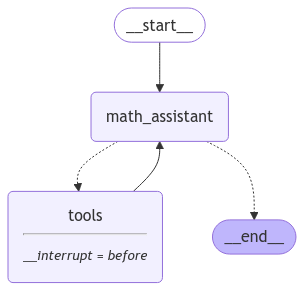

In [24]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

from IPython.display import Image, display
from langgraph.graph.state import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing import Annotated, List
from typing_extensions import TypedDict

sys_message = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

class State(TypedDict):
    messages : Annotated[List, add_messages]

def math_assistant(state:State):
    return {'messages':llm_with_tools.invoke([sys_message] + state['messages'])}


builder = StateGraph(State)
builder.add_node('math_assistant', math_assistant)
builder.add_node('tools', ToolNode(tools=tools))
builder.add_edge(START, 'math_assistant')
builder.add_conditional_edges('math_assistant', tools_condition)
builder.add_edge('tools', 'math_assistant')
memory = MemorySaver()
graph = builder.compile(interrupt_before=['tools'], checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [27]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_jYxmyyXkX2qZjxqJxBmyXGC8)
 Call ID: call_jYxmyyXkX2qZjxqJxBmyXGC8
  Args:
    a: 2
    b: 3


In [29]:
current_state = graph.get_state(thread)
current_state.next

('tools',)

In [30]:
for event in graph.stream(None, thread, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_jYxmyyXkX2qZjxqJxBmyXGC8)
 Call ID: call_jYxmyyXkX2qZjxqJxBmyXGC8
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [31]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()


## getting the human feedback 
user_approval = input('Do you want to use the tool? (Yes/No)')
if user_approval.lower()=='yes':
    for event in graph.stream(None, thread, stream_mode='values'):
        event['messages'][-1].pretty_print()
else:
    print('Cancelled by the user')

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_zfH99rR1YnktL0vX9V7xXxxp)
 Call ID: call_zfH99rR1YnktL0vX9V7xXxxp
  Args:
    a: 2
    b: 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_zfH99rR1YnktL0vX9V7xXxxp)
 Call ID: call_zfH99rR1YnktL0vX9V7xXxxp
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [35]:
from langgraph_sdk import get_client

client = get_client(url="http://localhost:57664")

input_message = {'messages':HumanMessage(content='Multiply 2 and 3')}
thread = await client.threads.create()
async for event in client.runs.stream(thread['thread_id'],
                                      assistant_id='agent',
                                      input = input_message,
                                      stream_mode ='values',
                                      interrupt_before=['tools']
                                      ):
    print('Receiving new type of event:', event.event)
    messages = event.data.get('messages', [])
    if messages:
        print(messages[-1])
    print('-'*50)

Receiving new type of event: metadata
--------------------------------------------------
Receiving new type of event: values
{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'cf2a32ad-c98f-4485-90ed-147c2b51a44b', 'example': False}
--------------------------------------------------
Receiving new type of event: values
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_M14XDIgwOzKswX5Jbn6s4UCe', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', '

In [36]:
async for event in client.runs.stream(thread['thread_id'],
                                      assistant_id='agent',
                                      input=None,
                                      stream_mode='values',
                                      interrupt_before=['tools']):
    print(f'Receiving the new type of event:{event.event}...')
    messages = event.data.get('messages', [])
    if messages:
        print(messages[-1])
    print('-'*50)

Receiving the new type of event:metadata...
--------------------------------------------------
Receiving the new type of event:values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_M14XDIgwOzKswX5Jbn6s4UCe', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_c7ca0ebaca', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-dba8445b-b1b8-436b-9d84-9acf68900eeb-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_M14XDIgwOzKswX5Jbn6s4UCe', 'type': 'tool_call'}], 'invalid

## edit state human feedback

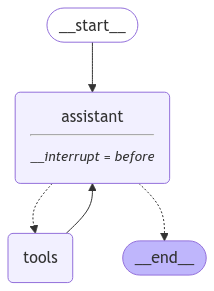

In [56]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)


from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [58]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "40"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [59]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='c8892e9f-57e7-4290-bfab-86fa401e863e')]}, next=('assistant',), config={'configurable': {'thread_id': '40', 'checkpoint_ns': '', 'checkpoint_id': '1efb628b-dc1c-6da6-8000-c36e4868ecb0'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '40', 'step': 0, 'parents': {}}, created_at='2024-12-09T12:25:57.031660+00:00', parent_config={'configurable': {'thread_id': '40', 'checkpoint_ns': '', 'checkpoint_id': '1efb628b-dc19-6cbe-bfff-9ec75c615988'}}, tasks=(PregelTask(id='071869e2-e2fb-3277-d970-47262c0f5485', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [60]:
graph.update_state(thread,
                   {'messages':[HumanMessage(content="No, actually 3 and 3!")]})

{'configurable': {'thread_id': '40',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb628c-23d6-6df4-8001-222a5fac554e'}}

In [61]:
new_state = graph.get_state(thread)
new_state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='c8892e9f-57e7-4290-bfab-86fa401e863e'), HumanMessage(content='No, actually 3 and 3!', additional_kwargs={}, response_metadata={}, id='4bf3cf0b-1768-4b3c-9f5e-2fe109afc101')]}, next=('assistant',), config={'configurable': {'thread_id': '40', 'checkpoint_ns': '', 'checkpoint_id': '1efb628c-23d6-6df4-8001-222a5fac554e'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='No, actually 3 and 3!', additional_kwargs={}, response_metadata={}, id='4bf3cf0b-1768-4b3c-9f5e-2fe109afc101')]}}, 'thread_id': '40', 'step': 1, 'parents': {}}, created_at='2024-12-09T12:26:04.552745+00:00', parent_config={'configurable': {'thread_id': '40', 'checkpoint_ns': '', 'checkpoint_id': '1efb628b-dc1c-6da6-8000-c36e4868ecb0'}}, tasks=(PregelTask(id='cb4c41c3-4887-b9c0-6300-ebfe6f37b455', name='assistant', path=('__pregel_pull', 'assistant'), error=None

In [62]:
new_state.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='c8892e9f-57e7-4290-bfab-86fa401e863e'),
  HumanMessage(content='No, actually 3 and 3!', additional_kwargs={}, response_metadata={}, id='4bf3cf0b-1768-4b3c-9f5e-2fe109afc101')]}

In [63]:
for m in new_state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually 3 and 3!


In [64]:
for event in graph.stream(None, thread, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_V4yQJoJ7JbgAJtL6E1HvVSgS)
 Call ID: call_V4yQJoJ7JbgAJtL6E1HvVSgS
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


## Updating agent state with the human's feedback

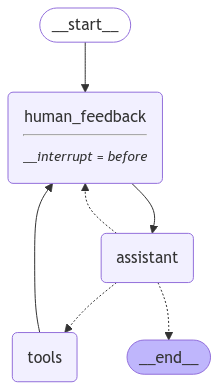

In [66]:
sys_message = SystemMessage(content='You are a helpful assistant tasked with performing arithmetic on a set of inputs.')

def human_feedback(state:State):
    pass

def assistant(state:State):
    return {'messages':llm_with_tools.invoke([sys_message]+state['messages'])}

builder = StateGraph(State)
builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))
builder.add_node('human_feedback', human_feedback)

builder.add_edge(START, 'human_feedback')
builder.add_edge('human_feedback', 'assistant')
builder.add_conditional_edges('assistant', tools_condition)
builder.add_edge('tools', 'human_feedback')

graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [68]:
initial_input = {'messages':'Multiply 2 and 3'}
config = {'configurable':{'thread_id':6}}

for event in graph.stream(initial_input, config, stream_mode='values'):
    event['messages'][-1].pretty_print()


# update the state using input
user_input = input('Tell me how you want to update the state?')
graph.update_state(config, {'messages':user_input}, as_node='human_feedback')

for event in graph.stream(None, config=config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

no, multiply 3 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_qLl2lrwJXHDlSDrMQQnNaFid)
 Call ID: call_qLl2lrwJXHDlSDrMQQnNaFid
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [69]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9


# Dynamic Breakpoints

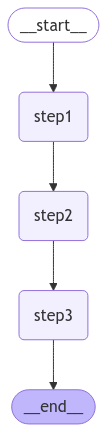

In [71]:
from IPython.display import display, Image
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph.state import StateGraph, START, END

class State(TypedDict):
    input : str 


def step1(state:State):
    print('Step 1')
    return state 

def step2(state:State):
    if len(state['input'])>5:
        raise NodeInterrupt(f"Received  input that is longer than 5 characters:{state['input']}")
    
    print('Step 2')
    return state

def step3(state:State):
    print('step 3')
    return state 


builder = StateGraph(State)
builder.add_node('step1', step1)
builder.add_node('step2', step2)
builder.add_node('step3', step3)
builder.add_edge(START, 'step1')
builder.add_edge('step1', 'step2')
builder.add_edge('step2', 'step3')
builder.add_edge('step3', END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))



In [72]:
initial_input = {'input':'hello world'}
thread_config = {'configurable':{'thread_id':7}}
for event in graph.stream(initial_input, thread_config, stream_mode='values'):
    print(event)

{'input': 'hello world'}
Step 1
{'input': 'hello world'}


In [73]:
state = graph.get_state(thread_config)
print(state.next)

('step2',)


In [74]:
print(state.tasks)

(PregelTask(id='c25a08f4-9847-d54a-906f-e2782d8bc004', name='step2', path=('__pregel_pull', 'step2'), error=None, interrupts=(Interrupt(value='Received  input that is longer than 5 characters:hello world', resumable=False, ns=None, when='during'),), state=None, result=None),)


In [75]:
for event in graph.stream(None, thread_config, stream_mode='values'):
    print(event)

{'input': 'hello world'}


In [77]:
graph.get_state(thread_config).next

('step2',)

In [78]:
graph.update_state(thread_config, {'input':'hi'})

{'configurable': {'thread_id': 7,
  'checkpoint_ns': '',
  'checkpoint_id': '1efb63c0-f36d-6308-8002-886fd682ab69'}}

In [79]:
for event in graph.stream(None, thread_config, stream_mode='values'):
    print(event)

{'input': 'hi'}
Step 2
{'input': 'hi'}
step 3
{'input': 'hi'}


In [82]:
from langgraph_sdk import get_client
from pprint import pprint

URL = "http://localhost:57664"
client = get_client(url=URL)

assistants = await client.assistants.search()
pprint(assistants)

[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'config': {},
  'created_at': '2024-12-09T10:28:41.077546+00:00',
  'graph_id': 'dynamic_breakpoints',
  'metadata': {'created_by': 'system'},
  'name': 'dynamic_breakpoints',
  'updated_at': '2024-12-09T10:28:41.077546+00:00',
  'version': 1},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'config': {},
  'created_at': '2024-12-09T10:28:41.075276+00:00',
  'graph_id': 'agent',
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'updated_at': '2024-12-09T10:28:41.075276+00:00',
  'version': 1}]


In [83]:
thread = await client.threads.create()
input_dict = {'input':'hello world'}

async for chunk in client.runs.stream(thread['thread_id'],
                                      assistant_id='dynamic_breakpoints',
                                      input = input_dict,
                                      stream_mode='values'):
    print(f"Receiving the new type of event:{chunk.event}")
    print(chunk.data)
    print('\n\n')

Receiving the new type of event:metadata
{'run_id': '1efb63cd-538a-6234-8471-b24bb3024238', 'attempt': 1}



Receiving the new type of event:values
{'input': 'hello world'}



Receiving the new type of event:values
{'input': 'hello world'}





In [84]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state['next']

['step_2']

In [85]:
await client.threads.update_state(thread['thread_id'], {'input':'hi'})

{'checkpoint': {'thread_id': '604efa35-499f-4b62-9a3a-b2da874ad879',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb63d0-2ac7-673a-8002-53e4a08051c5'},
 'configurable': {'thread_id': '604efa35-499f-4b62-9a3a-b2da874ad879',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb63d0-2ac7-673a-8002-53e4a08051c5'},
 'checkpoint_id': '1efb63d0-2ac7-673a-8002-53e4a08051c5'}

In [86]:
async for chunk in client.runs.stream(thread['thread_id'],
                                      assistant_id='dynamic_breakpoints',
                                      input=None,
                                      stream_mode='values'):
    print(f"Received new type of input:{chunk.event}")
    print(chunk.data)
    print('\n\n')

Received new type of input:metadata
{'run_id': '1efb63d3-49ff-67e6-9bdd-d41f8920903f', 'attempt': 1}



Received new type of input:values
{'input': 'hi'}



Received new type of input:values
{'input': 'hi'}



Received new type of input:values
{'input': 'hi'}





## Time Travel

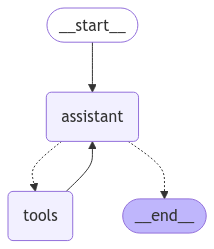

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_5owgiehebjYVvMfO1WG0qXBE)
 Call ID: call_5owgiehebjYVvMfO1WG0qXBE
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [89]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)


from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))



# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

In [91]:
pprint(graph.get_state({'configurable': {'thread_id': '1'}}))

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='8f5c5e38-44ed-47d5-bf9f-f4d1c28d1aa8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5owgiehebjYVvMfO1WG0qXBE', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9d50cd990b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-22662d5c-9d4a-4514-b8dc-8e09926f1971-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_5owgiehebjYVvMfO1WG0qXBE', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1

In [93]:
all_states = [s for s in graph.get_state_history(thread)]
pprint(all_states)

[StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='8f5c5e38-44ed-47d5-bf9f-f4d1c28d1aa8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5owgiehebjYVvMfO1WG0qXBE', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9d50cd990b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-22662d5c-9d4a-4514-b8dc-8e09926f1971-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_5owgiehebjYVvMfO1WG0qXBE', 'type': 'tool_call'}], usage_metadata={'input_tokens': 

In [94]:
to_replay = all_states[-2]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='8f5c5e38-44ed-47d5-bf9f-f4d1c28d1aa8')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb6407-31da-6190-8000-36fe8a98ac82'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2024-12-09T15:15:39.725851+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb6407-31d7-62ce-bfff-e44fb0337adb'}}, tasks=(PregelTask(id='e9e24c99-19dc-f920-f802-8939f7ecb80c', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5owgiehebjYVvMfO1WG0qXBE', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_t

In [95]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='8f5c5e38-44ed-47d5-bf9f-f4d1c28d1aa8')]}

In [96]:
to_replay.next

('assistant',)

In [97]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb6407-31da-6190-8000-36fe8a98ac82'}}

In [98]:
for event in graph.stream(None, to_replay.config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_dw3LjzAPuLJBJHh0Hs9tZMG4)
 Call ID: call_dw3LjzAPuLJBJHh0Hs9tZMG4
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


#### to_fork

In [99]:
to_fork = all_states[-2]
to_fork

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='8f5c5e38-44ed-47d5-bf9f-f4d1c28d1aa8')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb6407-31da-6190-8000-36fe8a98ac82'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2024-12-09T15:15:39.725851+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb6407-31d7-62ce-bfff-e44fb0337adb'}}, tasks=(PregelTask(id='e9e24c99-19dc-f920-f802-8939f7ecb80c', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5owgiehebjYVvMfO1WG0qXBE', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_t

In [100]:
to_fork.values['messages']

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='8f5c5e38-44ed-47d5-bf9f-f4d1c28d1aa8')]

In [101]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb6407-31da-6190-8000-36fe8a98ac82'}}

In [103]:
fork_config = graph.update_state(to_fork.config, 
                                 {'messages':HumanMessage(content='Multiply by 5 and 3',
                                                          id = to_fork.values['messages'][0].id)})

In [104]:
new_states_history = [s for s in graph.get_state_history(thread)]
pprint(new_states_history)

[StateSnapshot(values={'messages': [HumanMessage(content='Multiply by 5 and 3', additional_kwargs={}, response_metadata={}, id='8f5c5e38-44ed-47d5-bf9f-f4d1c28d1aa8')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb6471-6187-6a18-8001-df0cd071ad1a'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': HumanMessage(content='Multiply by 5 and 3', additional_kwargs={}, response_metadata={}, id='8f5c5e38-44ed-47d5-bf9f-f4d1c28d1aa8')}}, 'thread_id': '1', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1efb6407-31da-6190-8000-36fe8a98ac82'}, created_at='2024-12-09T16:03:10.140809+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb6407-31da-6190-8000-36fe8a98ac82'}}, tasks=(PregelTask(id='bc3e47f9-8b06-3424-0a11-f33ccf3647ce', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),)),
 StateSnapsho

In [105]:
graph.get_state({'configurable':{'thread_id':1}})

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': 1}}, metadata=None, created_at=None, parent_config=None, tasks=())

In [106]:
for event in graph.stream(None, fork_config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply by 5 and 3
================================== Ai Message ==================================

To multiply a number by 5 and 3, we can perform the multiplication operations separately for each multiplier. Could you please provide the number you want to multiply by 5 and 3?


## Asynchronous running

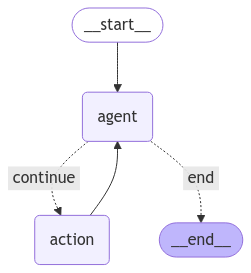

Output from node 'agent':
---
================================== Ai Message ==================================

5 plus 3 equals 8.

---



In [11]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from typing import Literal
from langgraph.graph import END, StateGraph, START


llm = ChatOpenAI(model='gpt-4o-mini')

class State(TypedDict):
    messages: Annotated[list, add_messages]


@tool
def add(a:int, b:int)->int:
    """Add two integers"""
    return a+b

tools = [add]
llm_with_tools = llm.bind_tools(tools=tools)



# Define the function that determines whether to continue or not
def should_continue(state: State) -> Literal["end", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"
    

async def call_model(state:State):
    response = await llm.ainvoke(state['messages'])
    return {'messages':response}

#building graph
workflow = StateGraph(State)
workflow.add_node("agent", call_model)
workflow.add_node('action', ToolNode(tools=tools))
workflow.add_edge(START, "agent")
workflow.add_conditional_edges('agent', should_continue, {'continue':'action', 'end':END})
workflow.add_edge('action', 'agent')
app = workflow.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


inputs = {'messages':HumanMessage(content='Add 5 and 3')}
async for output in app.astream(inputs, stream_mode="updates"):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        value['messages'].pretty_print()
        # print(value["messages"][-1].pretty_print())
    print("\n---\n")

In [12]:
inputs = ['Add 5 and 4',
          'Add 15 and 4',
          'Add 25 and 4',
          'Add 35 and 4',
          'Add 45 and 4']

for i in inputs:
    async for output in app.astream({'messages':HumanMessage(content=i)}, stream_mode="updates"):
        # stream_mode="updates" yields dictionaries with output keyed by node name
        for key, value in output.items():
            print(f"Output from node '{key}':")
            print("---")
            value['messages'].pretty_print()
            # print(value["messages"][-1].pretty_print())
        print("\n---\n")

Output from node 'agent':
---
================================== Ai Message ==================================

5 plus 4 equals 9.

---

Output from node 'agent':
---
================================== Ai Message ==================================

15 plus 4 equals 19.

---

Output from node 'agent':
---
================================== Ai Message ==================================

25 plus 4 equals 29.

---

Output from node 'agent':
---
================================== Ai Message ==================================

35 plus 4 equals 39.

---

Output from node 'agent':
---
================================== Ai Message ==================================

45 plus 4 equals 49.

---



## Sub Graphs

In [59]:
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')

In [ ]:
from typing import List, Annotated, Optional
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class Log(TypedDict):
    id : str
    question : str
    docs : Optional[str]
    answer : str
    grade : Optional[int]
    grader : Optional[str]
    feedback : Optional[str]



## MapReduce

In [87]:
from langchain_openai import ChatOpenAI

subject_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are the bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID of the first joke:\n\n {jokes}"""

model = ChatOpenAI(model='gpt-4o-mini', temperature=0)

In [88]:
import operator
from typing import Annotated, List
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subject(BaseModel):
    subjects : List[str]

class BestJoke(BaseModel):
    id : int

class OverallState(TypedDict):
    topic : str
    subjects: List[str]
    jokes : Annotated[List, operator.add]
    best_selected_joke : str 

In [ ]:
def generate_topics(state:OverallState):
    prompt = subject_prompt.format(topic=state['topic'])
    response = model.with_structured_output(Subject).invoke(prompt)
    return {'subjects':response.subjects}


from langgraph.constants import Send
def continue_to_jokes(state:OverallState):
    return [Send('generate_joke', {'Subject':s}) for s in state['subjects']]


## Trustcall

In [60]:
!pip install -U langchain langchain-core langchain-community langsmith langgraph langchain-openai langchain-groq trustcall transformers sentence-transformers

  Using cached tokenizers-0.21.0-cp39-abi3-macosx_11_0_arm64.whl.metadata (6.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 5.0 MB/s eta 0:00:00 0:00:01
Using cached tokenizers-0.21.0-cp39-abi3-macosx_11_0_arm64.whl (2.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: openai
    Found existing installation: openai 1.55.3
    Uninstalling openai-1.55.3:
      Successfully uninstalled openai-1.55.3
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.1.147
    Uninstalling langsmith-0.1.147:
      Successfully uninstalled langsmith-0.1.147
  Attempting uninstall: langgraph-sdk
    Found existing installation: langgraph-sdk 0.1.40
 

In [75]:
from langchain_openai import ChatOpenAI
from trustcall import create_extractor
from pydantic import BaseModel, Field
from typing import List

# Define your schema
class UserProfile(BaseModel):
    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")

# Initialize the ChatGroq model
llm = ChatOpenAI(model="gpt-4o-mini")

# Create an extractor using TrustCall
trustcall_extractor = create_extractor(llm, tools=[UserProfile], tool_choice="UserProfile")

# Prepare conversation input
conversation = [
    {"role": "user", "content": "Hi, I'm Kathan."},
    {"role": "assistant", "content": "Nice to meet you, Kathan."},
    {"role": "user", "content": "I really like driving around the city."}
]

# Invoke the extractor to get structured data
system_msg = "Extract the user profile from the following conversation"
result = trustcall_extractor.invoke({
    "messages": [{"role": "system", "content": system_msg}] + conversation
})

# Print extracted responses
print(result['responses'])


[UserProfile(user_name='Kathan', interests=['driving around the city'])]


In [85]:
from trustcall import create_extractor
from pydantic import BaseModel, Field
from typing import List
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()


# Define your schema
class UserProfile(BaseModel):
    """
    Creating user profile from the given content
    """
    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")

# Initialize the ChatGroq model
groq_api_key = os.getenv('GROQ_API_KEY')
llm = ChatGroq(groq_api_key=groq_api_key, verbose=True, model_name = 'llama3-8b-8192')

# Create an extractor using TrustCall
trustcall_extractor = create_extractor(llm, tools=[UserProfile], tool_choice="UserProfile")

# Prepare conversation input
conversation = [
    {"role": "user", "content": "Hi, I'm Kathan."},
    {"role": "assistant", "content": "Nice to meet you, Kathan."},
    {"role": "user", "content": "I really like driving around the city."}
]

# Invoke the extractor to get structured data
system_msg = "Extract the user profile from the following conversation"
result = trustcall_extractor.invoke({
    "messages": [{"role": "system", "content": system_msg}] + conversation
})

# Print extracted responses
print(result['responses'])

[UserProfile(user_name='Kathan', interests=['driving around the city'])]
